# DA5401 Assignment 6 - Imputation via Regression for Missing data

### Problem Statement

We are working on a credit card risk assessment project, we are provided with a dataset which has missing values in several important feature columns. The presence of missing data prevents the immediate application of classification methods.  
We need to implement various strategies for handling this missing data and then use the resulting clean datasets to train and evaluate a classification model

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Part A : Data Preprocessing and Imputation

### Load and Prepare Data

In [2]:
df = pd.read_csv('UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
df.shape

(30000, 25)

This dataset has 30000 datapoints and 25 columns, of which one is the target variable.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

We can see that, **initially, there are no null values** in the dataset.

### Artificially Introducing MAR Missing values

We choose the columns **BILL_AMT2** and **PAY_AMT5** to introduce MAR values.  
We choose the column **AGE** to be the dependency column on which the absence of data depends on.

In [5]:
cols_for_MAR = ['BILL_AMT2', 'PAY_AMT5']
dependency_col = ['AGE']

We define a function to introduce MAR.  
**MAR (Missing At Random) means that the missingness in one column depends on the values of another column** - not completely random but correlated with other features.

In [6]:
def introduce_MAR(data, columns, dependency_col):
    np.random.seed(27)
    df_mar = data.copy()

    for col in columns:
        # Create missingness probability based on dependency column
        dependency_values = df_mar[dependency_col]

        #Normalize dependency values to better compute probability values
        scaler = StandardScaler()
        dependency_scaled = scaler.fit_transform(dependency_values.values.reshape(-1, 1)).flatten()

        # Convert to probabilities (Higher absolute values ==> higher probabilities)
        missing_probs = 1 / (1 + np.exp(-dependency_scaled))  # Sigmoid function
        missing_probs = (missing_probs - missing_probs.min()) / (missing_probs.max() - missing_probs.min()) * 0.075 * 2

        mask = np.random.random(len(df_mar)) < missing_probs
        df_mar.loc[mask, col] = np.nan
        
    return df_mar
    

In [7]:
df_missing = introduce_MAR(df, cols_for_MAR, dependency_col)

### Verify number of missing values

In [8]:
df_missing[cols_for_MAR].isnull().sum()

BILL_AMT2    1704
PAY_AMT5     1672
dtype: int64

In [9]:
df_missing.isnull().any(axis=1).sum()

np.int64(3249)

We can see that, there are approximately 1700 missing values in each of the 2 columns, making a total of around 3250 rows with missing values in the entire dataset(since there will be some rows where both column values are missing).

### Divide dataset into features and target

In [10]:
X = df_missing.drop(columns = ['default.payment.next.month'])
y = df_missing['default.payment.next.month']

In [11]:
X.shape, y.shape

((30000, 24), (30000,))

## Imputation Strategy 1 : Baseline Imputation

In [12]:
df_A = df_missing.copy()

#### Replace missing values with median

In [13]:
df_A['BILL_AMT2'] = df_A['BILL_AMT2'].fillna(df_A['BILL_AMT2'].median())
df_A['PAY_AMT5'] = df_A['PAY_AMT5'].fillna(df_A['PAY_AMT5'].median())


df_A.isnull().any(axis=1).sum()

np.int64(0)

### Why is Median Imputation preferred over Mean Imputation

Mean Imputation replaces missing values with the average of available values.  
Median Imputation replaces missing values with the middle value.

Why Median imputation is preferred:  
- Median is robust to outliers whereas mean is strogly affected by outliers.
- If the features are skewed, replacing missing values with the mean will pull the distribution towards the direction of the skew.
- Median Imputation reduces bias and variance distortion but mean imputation can highly lower variance in the data

## Imputation Strategy 2 : Linear Regression

In [14]:
df_B = df_missing.copy()

We choose the column BILL_AMT2 for imputing the missing values

Divide into train and test data.  
Train data is the datapoints where BILL_AMT2 value is not null, and   
Test Data is the datapoints where BILL_AMT2 value is null.

In [15]:
df_B_train = df_B[df_B['BILL_AMT2'].notnull()]
df_B_test = df_B[df_B['BILL_AMT2'].isnull()]

In [16]:
y_B_train = df_B_train['BILL_AMT2']
X_B_train = df_B_train.drop(columns = ['BILL_AMT2', 'PAY_AMT5', 'default.payment.next.month'])

X_B_test = df_B_test.drop(columns = ['BILL_AMT2', 'PAY_AMT5', 'default.payment.next.month'])

In [17]:
scaler = StandardScaler()
X_B_train = scaler.fit_transform(X_B_train)
X_B_test = scaler.transform(X_B_test)

In [18]:
model = LinearRegression()

model.fit(X_B_train, y_B_train)

df_B.loc[df_B['BILL_AMT2'].isnull(), 'BILL_AMT2'] = model.predict(X_B_test)

We changed BILL_AMT2 column to be the output of linear regression, and we are changing PAY_AMT5 back to its original form.

In [19]:
df_B['PAY_AMT5'] = df['PAY_AMT5']
df_B['BILL_AMT2'].isnull().sum() , df_B['PAY_AMT5'].isnull().sum()

(np.int64(0), np.int64(0))

We can see that there are no null values remaining in the dataset.

### Underlying Assumption of Regression Imputation

The underlying assumption of Regression Imputation is that the missing values are Missing At Random (MAR). This means the likelihood of a data point being missing depends only on the values of other observed variables, not on the missing value itself.  
In such cases, the observed data contain enough information to model and predict the missing values accurately.  
For example, if BILL_AMT2 is missing more often for customers with low LIMIT_BAL, the missingness can be explained using that variable.  
Regression imputation works well under this assumption because it uses the relationships among existing variables to estimate plausible values for the missing ones.  

## Imputation Strategy 3 : Non-Linear Regression

In [20]:
df_C = df_missing.copy()

In [21]:
df_C_train = df_B[df_C['BILL_AMT2'].notnull()]
df_C_test = df_B[df_C['BILL_AMT2'].isnull()]

In [22]:
y_C_train = df_C_train['BILL_AMT2']
X_C_train = df_C_train.drop(columns = ['BILL_AMT2', 'PAY_AMT5', 'default.payment.next.month'])

X_C_test = df_C_test.drop(columns = ['BILL_AMT2', 'PAY_AMT5', 'default.payment.next.month'])

In [23]:
scaler = StandardScaler()
X_C_train = scaler.fit_transform(X_C_train)
X_C_test = scaler.transform(X_C_test)

In [24]:
model = DecisionTreeRegressor()

model.fit(X_C_train, y_C_train)

df_C.loc[df_C['BILL_AMT2'].isnull(), 'BILL_AMT2'] = model.predict(X_C_test)

We changed BILL_AMT2 column to be the output of Decision Tree regression, and we are changing PAY_AMT5 back to its original form.

In [25]:
df_C['PAY_AMT5'] = df['PAY_AMT5']
df_C['BILL_AMT2'].isnull().sum(), df_B['PAY_AMT5'].isnull().sum()

(np.int64(0), np.int64(0))

We can see that there are no null values remaining in the dataset.

## Part B : Model Training and Performance Assessment

### Data Split

In [26]:
X_A = df_A.drop(columns = ['default.payment.next.month'])
y_A = df_A['default.payment.next.month']
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, random_state = 42, stratify = y)

In [27]:
X_B = df_B.drop(columns = ['default.payment.next.month'])
y_B = df_B['default.payment.next.month']
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, random_state = 42, stratify = y)

In [28]:
X_C = df_C.drop(columns = ['default.payment.next.month'])
y_C = df_C['default.payment.next.month']
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, random_state = 42, stratify = y)

### 4th dataset by deleting rows with missing values

In [29]:
df_D = df_missing.dropna().copy()

In [30]:
print("Original shape:", df_missing.shape)
print("After deletion:", df_D.shape)

Original shape: (30000, 25)
After deletion: (26751, 25)


In [31]:
X_D = df_D.drop(columns = ['default.payment.next.month'])
y_D = df_D['default.payment.next.month']

X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(X_D, y_D, test_size=0.2, random_state = 42, stratify = y_D)

### Classifier Setup

In [32]:
def scaled_features(X_tr, X_te):
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)

    return X_tr_scaled, X_te_scaled

In [33]:
X_train_A_scaled , X_test_A_scaled = scaled_features(X_train_A, X_test_A)

X_train_B_scaled , X_test_B_scaled = scaled_features(X_train_B, X_test_B)

X_train_C_scaled , X_test_C_scaled = scaled_features(X_train_C, X_test_C)

X_train_D_scaled , X_test_D_scaled = scaled_features(X_train_D, X_test_D)

### Model Evaluation

In [34]:
def evaluate_Log_reg_model(X_tr, X_te, y_tr, y_te):
    model = LogisticRegression(class_weight = 'balanced', random_state = 44)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)

    return y_pred

In [35]:
print ("Classification Report for Model A:")
y_pred_A = evaluate_Log_reg_model(X_train_A_scaled, X_test_A_scaled, y_train_A, y_test_A)

classification_report_A = classification_report(y_test_A, y_pred_A)
print (classification_report_A)

Classification Report for Model A:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      4673
           1       0.37      0.62      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000



In [36]:
print ("Classification Report for Model B:")
y_pred_B = evaluate_Log_reg_model(X_train_B_scaled, X_test_B_scaled, y_train_B, y_test_B)

classification_report_B = classification_report(y_test_B, y_pred_B)
print (classification_report_B)

Classification Report for Model B:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      4673
           1       0.37      0.62      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000



In [37]:
print ("Classification Report for Model C:")
y_pred_C = evaluate_Log_reg_model(X_train_C_scaled, X_test_C_scaled, y_train_C, y_test_C)

classification_report_C = classification_report(y_test_C, y_pred_C)
print (classification_report_C)

Classification Report for Model C:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      4673
           1       0.37      0.62      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000



In [38]:
print ("Classification Report for Model D:")
y_pred_D = evaluate_Log_reg_model(X_train_D_scaled, X_test_D_scaled, y_train_D, y_test_D)

classification_report_D = classification_report(y_test_D, y_pred_D)
print (classification_report_D)

Classification Report for Model D:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      4173
           1       0.38      0.65      0.48      1178

    accuracy                           0.69      5351
   macro avg       0.63      0.68      0.63      5351
weighted avg       0.77      0.69      0.71      5351



## Part C : Comparative Analysis

### Results Comparison

In [39]:
def create_comparison_table(class_reports, model_names):
    """
    Create a comparison table from stored classification reports
    
    Parameters:
    class_reports: list of classification report dictionaries
    model_names: list of model names ['Median Imputation', 'Linear Regression Imputation', ...]
    """
    
    comparison_data = []
    
    for i, (model_name, report) in enumerate(zip(model_names, class_reports)):
        # Extract metrics for both classes
        metrics_0 = report['0']
        metrics_1 = report['1']
        accuracy = report['accuracy']
        macro_avg = report['macro avg']
        weighted_avg = report['weighted avg']
        
        model_metrics = {
            'Model': model_name,
            'Accuracy': f"{accuracy:.4f}",
            # Class 0 (Non-Default) metrics
            'Precision_0': f"{metrics_0['precision']:.4f}",
            'Recall_0': f"{metrics_0['recall']:.4f}",
            'F1_0': f"{metrics_0['f1-score']:.4f}",
            # Class 1 (Default) metrics - MOST IMPORTANT
            'Precision_1': f"{metrics_1['precision']:.4f}",
            'Recall_1': f"{metrics_1['recall']:.4f}",
            'F1_1': f"{metrics_1['f1-score']:.4f}",
            # Average metrics
            'Macro_Avg_F1': f"{macro_avg['f1-score']:.4f}",
            'Weighted_Avg_F1': f"{weighted_avg['f1-score']:.4f}",
            'Support_1': int(metrics_1['support'])  # Number of actual defaults
        }
        
        comparison_data.append(model_metrics)
    
    # Create DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    return comparison_df

In [40]:
classification_report_A = classification_report(y_test_A, y_pred_A, output_dict = True)
classification_report_B = classification_report(y_test_B, y_pred_B, output_dict = True)
classification_report_C = classification_report(y_test_C, y_pred_C, output_dict = True)
classification_report_D = classification_report(y_test_D, y_pred_D, output_dict = True)

class_reports = [classification_report_A, classification_report_B, classification_report_C, classification_report_D]
model_names = ['Median Imputation', 'Linear Regression Imputation', 'Non-Linear Regression Imputation', 'Listwise Deletion']

comparison_table = create_comparison_table(class_reports, model_names)
print("Comparison Table:")
print(comparison_table.to_string(index=False))

Comparison Table:
                           Model Accuracy Precision_0 Recall_0   F1_0 Precision_1 Recall_1   F1_1 Macro_Avg_F1 Weighted_Avg_F1  Support_1
               Median Imputation   0.6802      0.8656   0.6976 0.7726      0.3675   0.6187 0.4611       0.6169          0.7037       1327
    Linear Regression Imputation   0.6813      0.8667   0.6983 0.7734      0.3691   0.6217 0.4632       0.6183          0.7048       1327
Non-Linear Regression Imputation   0.6815      0.8667   0.6985 0.7736      0.3693   0.6217 0.4634       0.6185          0.7049       1327
               Listwise Deletion   0.6900      0.8763   0.7014 0.7792      0.3804   0.6494 0.4798       0.6295          0.7133       1178


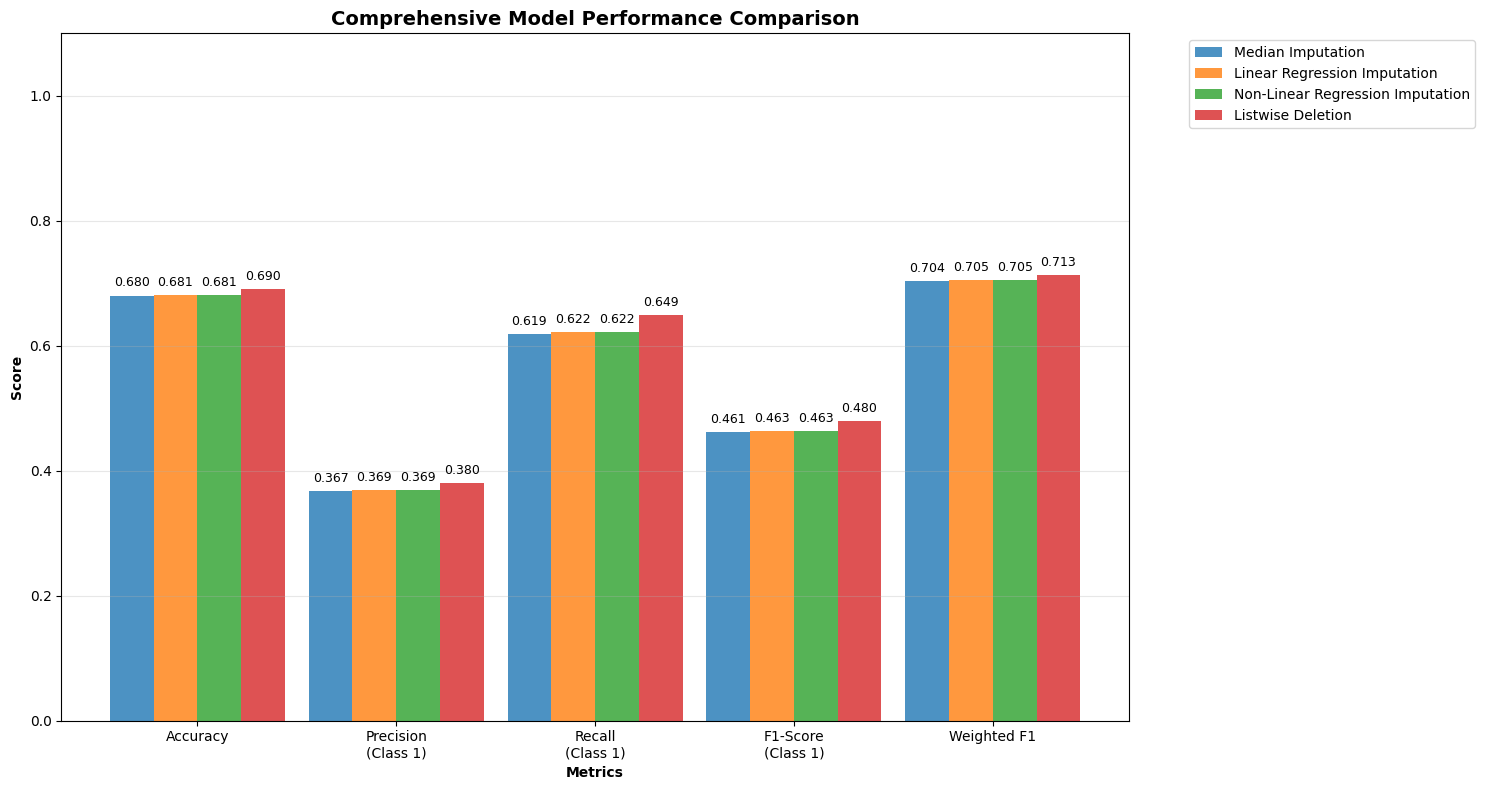

In [41]:
def plot_side_by_side_metrics(comparison_table):
    """
    Create a comprehensive side-by-side comparison plot
    """
    # Convert to numeric
    plot_df = comparison_table.copy()
    for col in ['Accuracy', 'Precision_1', 'Recall_1', 'F1_1', 'Weighted_Avg_F1']:
        plot_df[col] = plot_df[col].astype(float)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Metrics to plot
    metrics = ['Accuracy', 'Precision_1', 'Recall_1', 'F1_1', 'Weighted_Avg_F1']
    metric_labels = ['Accuracy', 'Precision\n(Class 1)', 'Recall\n(Class 1)', 'F1-Score\n(Class 1)', 'Weighted F1']
    
    # Bar positions
    x = np.arange(len(metrics))
    width = 0.22  # Width of each bar
    models = plot_df['Model'].tolist()
    
    # Create bars for each model
    for i, model in enumerate(models):
        values = [plot_df.loc[plot_df['Model'] == model, metric].values[0] for metric in metrics]
        offset = (i - len(models)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=model, alpha=0.8)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Customize the plot
    ax.set_xlabel('Metrics', fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Comprehensive Model Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.set_ylim(0, 1.1)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_side_by_side_metrics(comparison_table)

## Efficacy Discussion

### Trade-off between Listwise Deletion and Imputation Models

Listwise Deletion (Model D) achieved the highest overall accuracy (0.6900) and best F1-scores among all models. However, this comes with a significant trade-off — the sample size reduced from 1327 to 1178, meaning valuable data was discarded.
While this smaller, complete dataset might lead to cleaner patterns and slightly better performance, it also introduces bias if the missingness is not completely random. In real-world scenarios, this can reduce generalizability, as the model is trained on a less representative subset.
In contrast, imputation methods (Models A–C) retain the full dataset and preserve statistical power, even though their performance metrics are slightly lower (Accuracy ≈ 0.68 vs 0.69).

→ Summary:

Listwise Deletion: Slightly better performance, but risky due to data loss and potential bias.

Imputation: Slightly lower metrics, but safer and more robust for preserving information.

### Why might Model D perform poorly even if the imputed models perform worse?

1. **Loss of data → lower statistical power**
Dropping rows removes information. With fewer samples the model may be less stable and less able to learn rare-but-important patterns — especially for minority classes.

2. **Selection bias from non-random missingness**
If the rows that are missing are not Missing Completely At Random (MCAR) — e.g., missingness depends on the outcome or on a covariate — then the remaining dataset is a biased subset. A model trained on that biased subset can report deceptively good metrics on similar biased holdouts but fail on real-world data.

3. **Reduced ability to detect minority-class behavior**
If missingness disproportionately affects one class (often the minority), deletion removes many informative examples for that class → recall/F1 for that class may look okay in the reduced dataset but fail in deployment.

4. **Unreliable uncertainty estimates**
With fewer examples, confidence intervals widen and models become less robust to new data or domain shifts. Reported point metrics (accuracy, F1) hide this increased uncertainty.

### Linear vs Non-linear Regression Performance

Between the imputation models, **Non-Linear Regression Imputation** performed marginally better than Linear Regression Imputation, with a slightly higher Macro Avg F1 (0.6185 vs. 0.6183) and Weighted Avg F1 (0.7049 vs. 0.7048).

This small improvement suggests that the relationship between the missing feature and the predictors is mildly non-linear. The non-linear regression model was able to capture subtle, curved dependencies that linear regression could not fully represent, resulting in marginally better imputation quality and downstream classification performance.

## Final Recommendation

Preferred Method: Non-Linear Regression Imputation (Model C).

1. **Data Retention**: Retains all 1327 samples, avoiding loss of potentially informative data.

2. **Captures Complex Relationships**: Slightly better than Linear Regression Imputation (Macro F1 0.6185 vs 0.6183) due to ability to model non-linear dependencies between missing features and predictors.

3. **Generalizability**: Avoids biases introduced by Listwise Deletion, which reduces dataset size (1178 samples) and may skew class/feature distributions.

4. **Robustness**: Maintains statistical power, ensures minority-class representation, and reduces risk of overfitting to a “cleaner” subset.

5. **Trade-off Consideration**: While Listwise Deletion shows slightly higher raw metrics (Accuracy 0.6900, Weighted F1 0.7133), these may be misleading due to data loss and potential selection bias.